# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [48]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

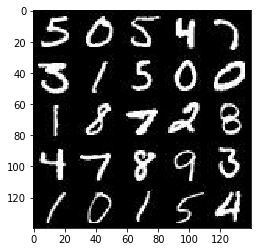

In [49]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

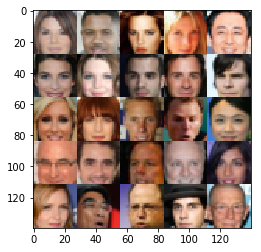

In [50]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [52]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [53]:
def c2d_layer(inputs, filters, kernel_size, strides, padding, training, alpha, applyleakyrelu=True):
    
    layer = tf.layers.conv2d(inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
    layer = tf.layers.batch_normalization(layer, training=training)
    if(applyleakyrelu):
        layer = tf.maximum(alpha * layer, layer)
    
    return layer

In [54]:
def discriminator(images, reuse=False, n_units=128, alpha=0.01, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):

        #def c2d_layer(inputs, filters, kernel_size, strides, padding, training, alpha, applyleakyrelu=True):
        # Input layer is 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = c2d_layer(relu1, 128, 5, 2, 'same', training, alpha)
        # 7 x 7 x 128
        
        x3 = c2d_layer(x2, 256, 5, 2, 'same', training, alpha)
        # 4 x 4 x 256
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def c2dt_layer(inputs, filters, kernel_size, strides, padding, training, alpha, applyleakyrelu=True):
    
    layer = tf.layers.conv2d_transpose(inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
    layer = tf.layers.batch_normalization(layer, training=training)
    if(applyleakyrelu):
        layer = tf.maximum(alpha * layer, layer)
    
    return layer

In [56]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # first fully conencted layer
        x0 = tf.layers.dense(z, 2 * 2 * 1024)
        
        # review comment: I suggest using layers with filters 1024, 512, 256, 128 as the layers 
        # for training your network. There is no need to use two layers each with 256 and 128 as
        # the number of filters.
        
        # reshape
        x0 = tf.reshape(x0, (-1, 2, 2, 1024))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        # now 2 x 2 x 1024
        
        #def c2dt_layer(inputs, filters, kernel_size, strides, padding, training, applyleakyrelu=True):
        x1 = c2dt_layer(x0, 512, 4, 2, 'same', is_train, alpha, True)
        # now 4 x 4 x 512
        
        x2 = c2dt_layer(x1, 256, 4, 1, 'valid', is_train, alpha, True)
        # now 7 x 7 x 256
        
        x3 = c2dt_layer(x2, 128, 4, 2, 'same', is_train, alpha, True)
        # now 14 x 14 x 128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

        # now 28 x 28 x 3
        out = tf.tanh(logits)

        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [57]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
   
    #d_loss_real = tf.reduce_mean(
#        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [74]:
import numpy as np

def save_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, savepath):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.savefig(savepath, bbox_inches='tight')

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [106]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, num_images_show = 25, print_every = 100, show_every = 100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    import time, datetime

    sample_z = np.random.uniform(-1, 1, size=z_dim)
    
    samples, losses = [], []
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        start = time.time()
        print("Start: {}, batch size {}, LR {}, Beta {}".format(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start)), batch_size, learning_rate, beta1))
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                # review comment: "You should increase batch size by a factor of two inside the inner for loop"
                batch_z = np.random.uniform(-1, 1, size=(2 * batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                # reviewer feedback: "Try running generator optimization one more time. It also helps in preventing discriminator loss from going to zero."
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step: {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    

               # if steps % show_every == 0:
                    #def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                  # skipping for now... show_generator_output(sess, num_images_show, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, num_images_show, input_z, data_shape[3], data_image_mode) 
        done = time.time()
        elapsed = done - start
        print("Final discriminator loss: {:.4f}, final generator loss: {:.4f}".format(losses[-1][0], losses[-1][1]))
        save_generator_output(sess, num_images_show, input_z, data_shape[3], data_image_mode, os.path.join('./out/batch-{}-lr{}-beta{}-d{:.4f}-g{:.4f}.jpg'.format(batch_size, learning_rate, beta1,losses[-1][0], losses[-1][1])))
        print("Done at {} - elapsed time: {}".format(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(done)), str(datetime.timedelta(seconds=elapsed))))

        
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 50 #64
z_dim = 150 #150
learning_rate = 0.001 #0.002
beta1 = 0.05 # 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Start: 2018-03-17 16:31:12, batch size 32, LR 0.0002, Beta 0.2
Epoch 1/1... Step: 100... Discriminator Loss: 0.3545... Generator Loss: 1.7414
Epoch 1/1... Step: 200... Discriminator Loss: 0.7913... Generator Loss: 0.7709
Epoch 1/1... Step: 300... Discriminator Loss: 0.2224... Generator Loss: 2.4461
Epoch 1/1... Step: 400... Discriminator Loss: 0.1547... Generator Loss: 2.8006
Epoch 1/1... Step: 500... Discriminator Loss: 0.0273... Generator Loss: 4.1249
Epoch 1/1... Step: 600... Discriminator Loss: 0.0392... Generator Loss: 4.0876
Epoch 1/1... Step: 700... Discriminator Loss: 0.0783... Generator Loss: 3.2202
Epoch 1/1... Step: 800... Discriminator Loss: 1.4947... Generator Loss: 0.4402
Epoch 1/1... Step: 900... Discriminator Loss: 1.6729... Generator Loss: 0.4078
Epoch 1/1... Step: 1000... Discriminator Loss: 1.5130... Generator Loss: 0.5466
Epoch 1/1... Step: 1100... Discriminator Loss: 1.5503... Generator Loss: 0.4722
Epoch 1/1... Step: 1200... Discriminator Loss: 1.5264... Generator

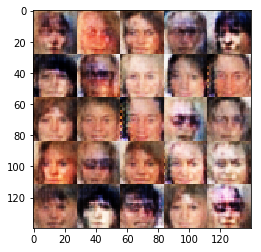

Final discriminator loss: 1.5501, final generator loss: 0.4777
Done at 2018-03-17 16:59:15 - elapsed time: 0:28:02.668465
Start: 2018-03-17 16:59:18, batch size 32, LR 0.0002, Beta 0.5
Epoch 1/1... Step: 100... Discriminator Loss: 1.4091... Generator Loss: 0.9568
Epoch 1/1... Step: 200... Discriminator Loss: 0.7052... Generator Loss: 1.3335
Epoch 1/1... Step: 300... Discriminator Loss: 2.3004... Generator Loss: 0.5062
Epoch 1/1... Step: 400... Discriminator Loss: 1.4474... Generator Loss: 0.6800
Epoch 1/1... Step: 500... Discriminator Loss: 1.5594... Generator Loss: 0.4916
Epoch 1/1... Step: 600... Discriminator Loss: 1.5538... Generator Loss: 0.5489
Epoch 1/1... Step: 700... Discriminator Loss: 1.9817... Generator Loss: 0.3621
Epoch 1/1... Step: 800... Discriminator Loss: 1.5641... Generator Loss: 0.6033
Epoch 1/1... Step: 900... Discriminator Loss: 1.4798... Generator Loss: 0.6001
Epoch 1/1... Step: 1000... Discriminator Loss: 1.3327... Generator Loss: 0.7351
Epoch 1/1... Step: 1100.

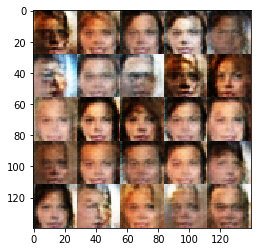

Final discriminator loss: 1.4537, final generator loss: 0.5704
Done at 2018-03-17 17:27:17 - elapsed time: 0:27:58.955482
Start: 2018-03-17 17:27:20, batch size 32, LR 0.0002, Beta 0.8
Epoch 1/1... Step: 100... Discriminator Loss: 1.4122... Generator Loss: 0.6420
Epoch 1/1... Step: 200... Discriminator Loss: 0.3840... Generator Loss: 1.7922
Epoch 1/1... Step: 300... Discriminator Loss: 0.6658... Generator Loss: 1.8302
Epoch 1/1... Step: 400... Discriminator Loss: 0.3626... Generator Loss: 1.5721
Epoch 1/1... Step: 500... Discriminator Loss: 0.1297... Generator Loss: 2.3786
Epoch 1/1... Step: 600... Discriminator Loss: 1.9510... Generator Loss: 0.4356
Epoch 1/1... Step: 700... Discriminator Loss: 1.7410... Generator Loss: 0.6192
Epoch 1/1... Step: 800... Discriminator Loss: 0.6412... Generator Loss: 1.4757
Epoch 1/1... Step: 900... Discriminator Loss: 3.2564... Generator Loss: 0.6401
Epoch 1/1... Step: 1000... Discriminator Loss: 1.4193... Generator Loss: 0.6414
Epoch 1/1... Step: 1100.

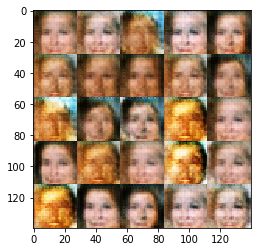

Final discriminator loss: 1.2880, final generator loss: 0.6965
Done at 2018-03-17 17:55:21 - elapsed time: 0:28:00.132460
Start: 2018-03-17 17:55:24, batch size 32, LR 0.0008, Beta 0.2
Epoch 1/1... Step: 100... Discriminator Loss: 1.4428... Generator Loss: 0.5607
Epoch 1/1... Step: 200... Discriminator Loss: 1.5524... Generator Loss: 0.5510
Epoch 1/1... Step: 300... Discriminator Loss: 1.5035... Generator Loss: 0.5284
Epoch 1/1... Step: 400... Discriminator Loss: 1.7923... Generator Loss: 0.3048
Epoch 1/1... Step: 500... Discriminator Loss: 1.5463... Generator Loss: 0.6099
Epoch 1/1... Step: 600... Discriminator Loss: 1.4981... Generator Loss: 0.5327
Epoch 1/1... Step: 700... Discriminator Loss: 1.4083... Generator Loss: 0.7493
Epoch 1/1... Step: 800... Discriminator Loss: 1.5686... Generator Loss: 0.8882
Epoch 1/1... Step: 900... Discriminator Loss: 1.4566... Generator Loss: 0.7476
Epoch 1/1... Step: 1000... Discriminator Loss: 1.3674... Generator Loss: 0.6814
Epoch 1/1... Step: 1100.

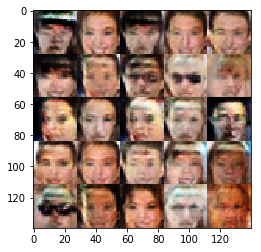

Final discriminator loss: 1.5272, final generator loss: 0.4288
Done at 2018-03-17 18:23:23 - elapsed time: 0:27:59.811652
Start: 2018-03-17 18:23:27, batch size 32, LR 0.0008, Beta 0.5
Epoch 1/1... Step: 100... Discriminator Loss: 1.9296... Generator Loss: 0.5535
Epoch 1/1... Step: 200... Discriminator Loss: 1.1013... Generator Loss: 0.9497
Epoch 1/1... Step: 300... Discriminator Loss: 1.4204... Generator Loss: 0.5747
Epoch 1/1... Step: 400... Discriminator Loss: 1.6680... Generator Loss: 0.4044
Epoch 1/1... Step: 500... Discriminator Loss: 0.9941... Generator Loss: 1.8825
Epoch 1/1... Step: 600... Discriminator Loss: 1.3329... Generator Loss: 1.1873
Epoch 1/1... Step: 700... Discriminator Loss: 1.5480... Generator Loss: 0.5867
Epoch 1/1... Step: 800... Discriminator Loss: 1.5566... Generator Loss: 0.4506
Epoch 1/1... Step: 900... Discriminator Loss: 1.3180... Generator Loss: 0.6918
Epoch 1/1... Step: 1000... Discriminator Loss: 1.0012... Generator Loss: 0.9160
Epoch 1/1... Step: 1100.

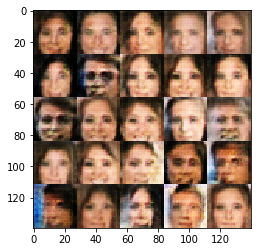

Final discriminator loss: 1.3304, final generator loss: 0.6342
Done at 2018-03-17 18:51:26 - elapsed time: 0:27:59.177325
Start: 2018-03-17 18:51:29, batch size 32, LR 0.0008, Beta 0.8
Epoch 1/1... Step: 100... Discriminator Loss: 0.6412... Generator Loss: 1.4107
Epoch 1/1... Step: 200... Discriminator Loss: 0.2122... Generator Loss: 1.9967
Epoch 1/1... Step: 300... Discriminator Loss: 0.0420... Generator Loss: 4.1084
Epoch 1/1... Step: 400... Discriminator Loss: 0.0926... Generator Loss: 2.8710
Epoch 1/1... Step: 500... Discriminator Loss: 1.7243... Generator Loss: 1.4791
Epoch 1/1... Step: 600... Discriminator Loss: 0.2588... Generator Loss: 2.1094
Epoch 1/1... Step: 700... Discriminator Loss: 2.6219... Generator Loss: 0.2073
Epoch 1/1... Step: 800... Discriminator Loss: 2.3173... Generator Loss: 0.6562
Epoch 1/1... Step: 900... Discriminator Loss: 2.8324... Generator Loss: 0.6138
Epoch 1/1... Step: 1000... Discriminator Loss: 0.5668... Generator Loss: 1.6820
Epoch 1/1... Step: 1100.

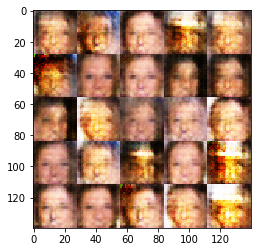

Final discriminator loss: 1.6460, final generator loss: 0.6951
Done at 2018-03-17 19:19:29 - elapsed time: 0:28:00.209129
Start: 2018-03-17 19:19:32, batch size 32, LR 0.002, Beta 0.2
Epoch 1/1... Step: 100... Discriminator Loss: 0.9191... Generator Loss: 1.0640
Epoch 1/1... Step: 200... Discriminator Loss: 1.4477... Generator Loss: 0.6164
Epoch 1/1... Step: 300... Discriminator Loss: 1.4862... Generator Loss: 0.5761
Epoch 1/1... Step: 400... Discriminator Loss: 1.3744... Generator Loss: 0.4194
Epoch 1/1... Step: 500... Discriminator Loss: 1.4104... Generator Loss: 0.7778
Epoch 1/1... Step: 600... Discriminator Loss: 1.6410... Generator Loss: 0.3273
Epoch 1/1... Step: 700... Discriminator Loss: 1.3642... Generator Loss: 0.7739
Epoch 1/1... Step: 800... Discriminator Loss: 1.1781... Generator Loss: 0.6611
Epoch 1/1... Step: 900... Discriminator Loss: 1.3981... Generator Loss: 0.5550
Epoch 1/1... Step: 1000... Discriminator Loss: 1.3239... Generator Loss: 0.8404
Epoch 1/1... Step: 1100..

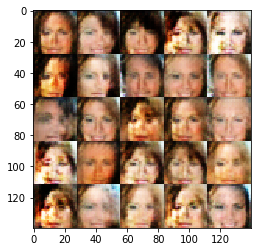

Final discriminator loss: 1.4985, final generator loss: 0.5706
Done at 2018-03-17 19:47:32 - elapsed time: 0:28:00.035910
Start: 2018-03-17 19:47:36, batch size 32, LR 0.002, Beta 0.5
Epoch 1/1... Step: 100... Discriminator Loss: 1.7411... Generator Loss: 1.2462
Epoch 1/1... Step: 200... Discriminator Loss: 1.4542... Generator Loss: 0.5951
Epoch 1/1... Step: 300... Discriminator Loss: 1.5980... Generator Loss: 0.9074
Epoch 1/1... Step: 400... Discriminator Loss: 1.3864... Generator Loss: 0.9015
Epoch 1/1... Step: 500... Discriminator Loss: 1.2821... Generator Loss: 0.7952
Epoch 1/1... Step: 600... Discriminator Loss: 1.8594... Generator Loss: 0.3538
Epoch 1/1... Step: 700... Discriminator Loss: 1.5825... Generator Loss: 0.6230
Epoch 1/1... Step: 800... Discriminator Loss: 1.3018... Generator Loss: 0.6026
Epoch 1/1... Step: 900... Discriminator Loss: 1.7589... Generator Loss: 0.3803
Epoch 1/1... Step: 1000... Discriminator Loss: 1.6052... Generator Loss: 0.5049
Epoch 1/1... Step: 1100..

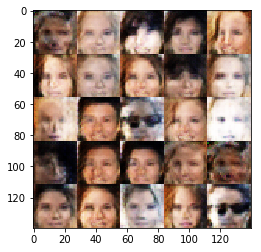

Final discriminator loss: 1.3892, final generator loss: 0.7019
Done at 2018-03-17 20:15:35 - elapsed time: 0:27:59.500378
Start: 2018-03-17 20:15:38, batch size 32, LR 0.002, Beta 0.8
Epoch 1/1... Step: 100... Discriminator Loss: 0.0092... Generator Loss: 5.2740
Epoch 1/1... Step: 200... Discriminator Loss: 1.8169... Generator Loss: 0.3307
Epoch 1/1... Step: 300... Discriminator Loss: 2.7829... Generator Loss: 7.1662
Epoch 1/1... Step: 400... Discriminator Loss: 0.8931... Generator Loss: 5.5865
Epoch 1/1... Step: 500... Discriminator Loss: 0.3390... Generator Loss: 3.0527
Epoch 1/1... Step: 600... Discriminator Loss: 0.5165... Generator Loss: 1.6823
Epoch 1/1... Step: 700... Discriminator Loss: 1.7615... Generator Loss: 0.3925
Epoch 1/1... Step: 800... Discriminator Loss: 1.3594... Generator Loss: 1.3623
Epoch 1/1... Step: 900... Discriminator Loss: 1.9098... Generator Loss: 0.9088
Epoch 1/1... Step: 1000... Discriminator Loss: 1.0593... Generator Loss: 1.9429
Epoch 1/1... Step: 1100..

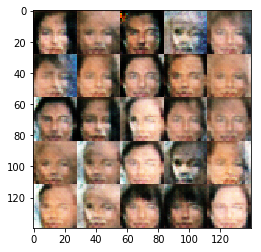

Final discriminator loss: 1.7299, final generator loss: 0.5226
Done at 2018-03-17 20:43:36 - elapsed time: 0:27:58.153022
Start: 2018-03-17 20:43:40, batch size 32, LR 0.008, Beta 0.2
Epoch 1/1... Step: 100... Discriminator Loss: 1.1102... Generator Loss: 0.6518
Epoch 1/1... Step: 200... Discriminator Loss: 1.0485... Generator Loss: 0.9755
Epoch 1/1... Step: 300... Discriminator Loss: 1.6001... Generator Loss: 1.3003
Epoch 1/1... Step: 400... Discriminator Loss: 1.3914... Generator Loss: 0.9656
Epoch 1/1... Step: 500... Discriminator Loss: 2.0329... Generator Loss: 0.2965
Epoch 1/1... Step: 600... Discriminator Loss: 1.6652... Generator Loss: 0.3961
Epoch 1/1... Step: 700... Discriminator Loss: 1.3219... Generator Loss: 0.6039
Epoch 1/1... Step: 800... Discriminator Loss: 1.3717... Generator Loss: 0.6878
Epoch 1/1... Step: 900... Discriminator Loss: 1.3937... Generator Loss: 0.6983
Epoch 1/1... Step: 1000... Discriminator Loss: 1.3567... Generator Loss: 0.7277
Epoch 1/1... Step: 1100..

In [ ]:
# trying out multiple values...


batch_size = 32, 64
z_dim = 100
learning_rate =  0.0002, 0.0008, .002, .008
beta1 = .2, 0.5, .8

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
for bs in batch_size:
    for lr in learning_rate:
        for b in beta1:
            with tf.Graph().as_default():
                train(epochs, bs, z_dim, lr, b, celeba_dataset.get_batches,
                      celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
batch_size = 64
z_dim = 100
learning_rate =  0.0002 
beta1 = .2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.